In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import json
import re


In [2]:
## Buscar todos los .log dentro de benchmark/logs_bench y subcarpetas
log_files = glob.glob("../benchmark/logs_bench/**/*.log", recursive=True)

print("Archivos encontrados:", log_files[:5])  # muestra solo los primeros
print("Total de archivos:", len(log_files))


Archivos encontrados: ['../benchmark/logs_bench/bench_worker4/endpoints.log', '../benchmark/logs_bench/bench_worker4/function_state.log', '../benchmark/logs_bench/bench_worker4/function_result.log', '../benchmark/logs_bench/bench_worker4/endpoint_state.log', '../benchmark/logs_bench/bench_worker4/security_policy.log']
Total de archivos: 9


In [3]:
records = []

for file in log_files:
    buffer = ""  # para JSON multilínea
    with open(file) as f:
        for line in f:
            line = line.strip()
            if not line:
                continue

            buffer += line
            if line.endswith("}"):  # asumimos que aquí termina un JSON
                try:
                    data = json.loads(buffer)
                    if "event" in data:  # solo logs válidos
                        data["worker"] = int(re.findall(r"worker(\d+)", file)[0])
                        records.append(data)
                except Exception as e:
                    print(f"⚠️ Error parseando en {file}: {e}")
                buffer = ""  # reiniciar buffer

df = pd.DataFrame(records)

print("Columnas disponibles:", df.columns.tolist())
df.head()



Columnas disponibles: ['event', 'path', 'status', 'elapsed', 'logger_name', 'worker']


,event,path,status,elapsed,logger_name,worker
0,POST.ENDPOINT,/api/v1/endpoints/,200,0.229,endpoints_worker4,4
1,POST.ENDPOINT,/api/v1/endpoints/,200,0.318,endpoints_worker4,4
2,POST.ENDPOINT,/api/v1/endpoints/,200,0.522,endpoints_worker4,4
3,POST.ENDPOINT,/api/v1/endpoints/,200,0.409,endpoints_worker4,4
4,POST.ENDPOINT,/api/v1/endpoints/,200,0.446,endpoints_worker4,4


In [24]:
# Separar operación y entidad (ejemplo: CREATE.ENDPOINT → CREATE, ENDPOINT)
df[['Operación', 'Entidad']] = df['event'].str.split('.', expand=True, n=1)

# Asegurar tipos correctos
df['elapsed'] = df['elapsed'].astype(float)
df['worker'] = df['worker'].astype(int)

df.head()



,event,path,status,elapsed,logger_name,worker,operation,entity,Operación,Entidad
0,POST.ENDPOINT,/api/v1/endpoints/,200,0.229,endpoints_worker4,4,POST,ENDPOINT,POST,ENDPOINT
1,POST.ENDPOINT,/api/v1/endpoints/,200,0.318,endpoints_worker4,4,POST,ENDPOINT,POST,ENDPOINT
2,POST.ENDPOINT,/api/v1/endpoints/,200,0.522,endpoints_worker4,4,POST,ENDPOINT,POST,ENDPOINT
3,POST.ENDPOINT,/api/v1/endpoints/,200,0.409,endpoints_worker4,4,POST,ENDPOINT,POST,ENDPOINT
4,POST.ENDPOINT,/api/v1/endpoints/,200,0.446,endpoints_worker4,4,POST,ENDPOINT,POST,ENDPOINT


In [25]:
metrics = df.groupby(['Entidad', 'Operación', 'worker']).agg(
    avg_time=('elapsed', 'mean'),
    min_time=('elapsed', 'min'),
    max_time=('elapsed', 'max'),
    std_time=('elapsed', 'std'),
    success_rate=('status', lambda x: (x == 200).mean())
).reset_index()

metrics



,Entidad,Operación,worker,avg_time,min_time,max_time,std_time,success_rate
0,ENDPOINT,DELETE,4,0.241438,0.045,0.582,0.117426,1.0
1,ENDPOINT,GET,4,0.240737,0.045,0.684,0.117137,1.0
2,ENDPOINT,POST,4,0.246834,0.047,0.594,0.119962,1.0
3,ENDPOINT,PUT,4,0.273391,0.051,0.652,0.123285,1.0
4,ENDPOINTSTATE,DELETE,4,0.138187,0.028,0.367,0.068661,1.0
5,ENDPOINTSTATE,GET,4,0.136345,0.027,0.396,0.068348,1.0
6,ENDPOINTSTATE,POST,4,0.142875,0.029,0.721,0.071335,1.0
7,ENDPOINTSTATE,PUT,4,0.155944,0.035,0.396,0.070226,1.0
8,FUNCTION,DELETE,4,0.151816,0.028,0.414,0.075503,1.0
9,FUNCTION,GET,4,0.200674,0.028,1.023,0.130349,1.0


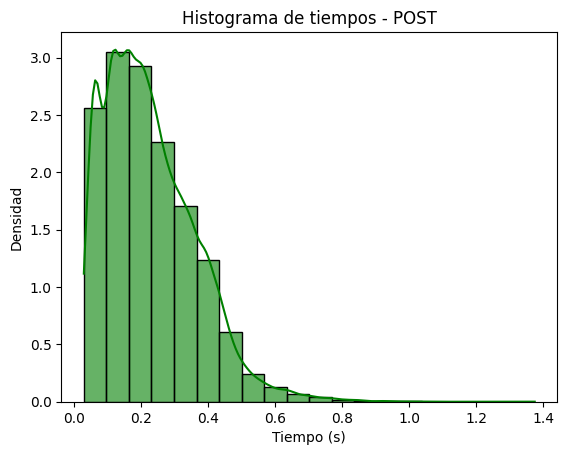

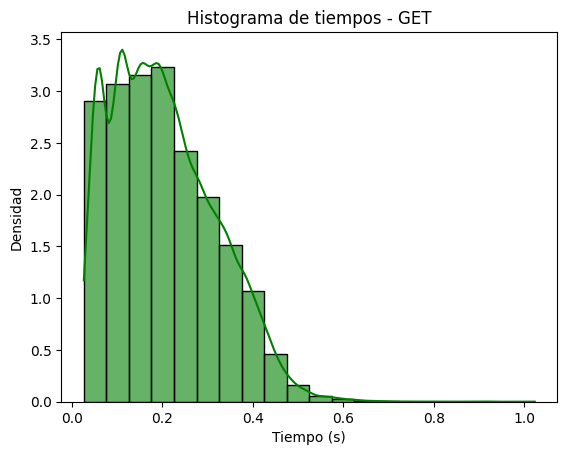

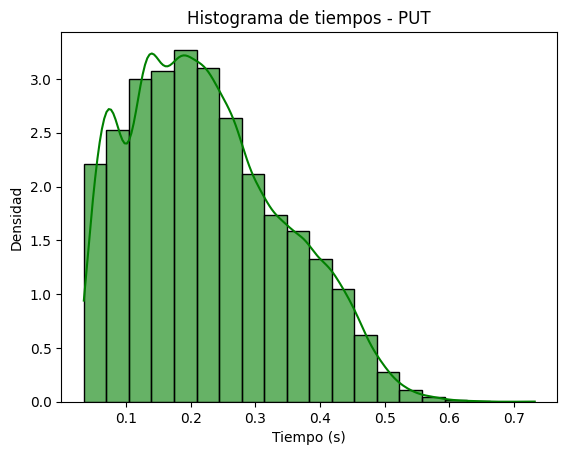

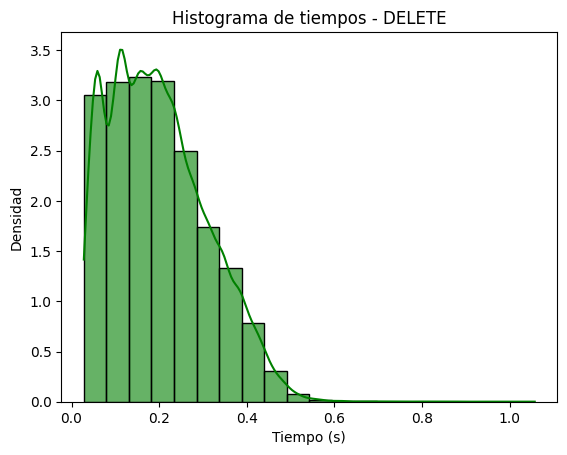

In [26]:
for op in df['Operación'].unique():
    subset = df[df['Operación'] == op]

    sns.histplot(
        subset['elapsed'],
        bins=20,
        kde=True,
        stat="density",
        alpha=0.6,
        color="green", 
    
    )
    plt.title(f"Histograma de tiempos - {op}")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Densidad")

    # Guardar en PNG y PDF


    plt.show()
    plt.close()



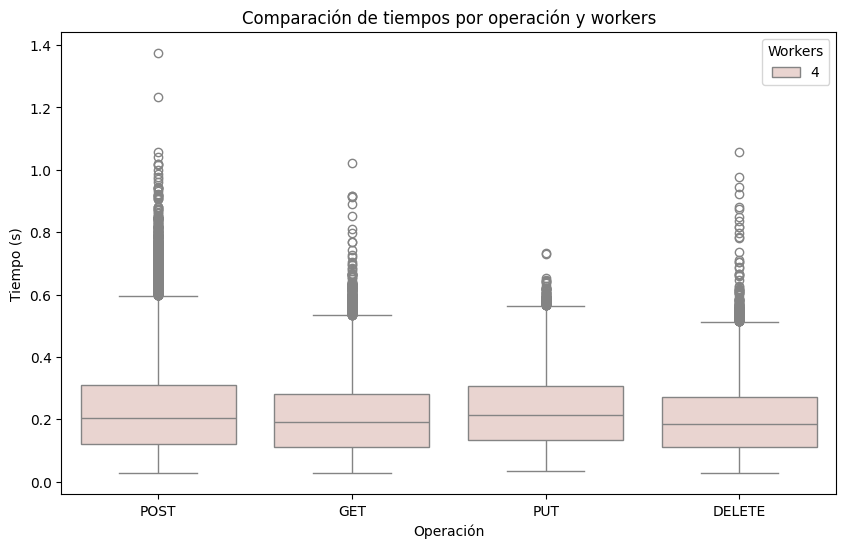

In [27]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='Operación', y='elapsed', hue='worker')
plt.title("Comparación de tiempos por operación y workers")
plt.ylabel("Tiempo (s)")
plt.xlabel("Operación")
plt.legend(title="Workers")
plt.show()



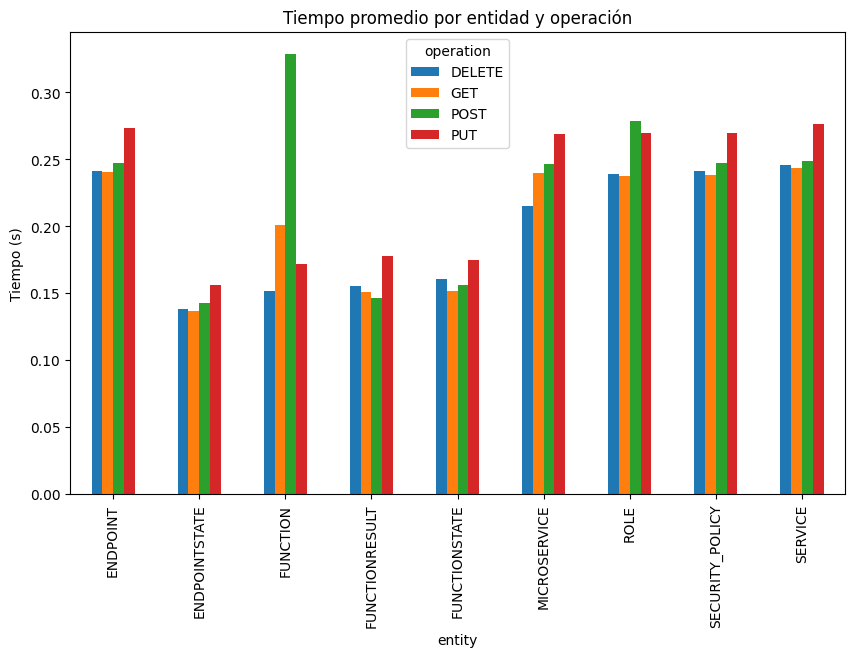

In [ ]:
avg_entity = df.groupby(['Entidad', 'Operación'])['elapsed'].mean().unstack()
avg_entity.plot(kind='bar', figsize=(10,6))
plt.title("Tiempo promedio por entidad y operación")
plt.ylabel("Tiempo (s)")
plt.show()

